# CS 109A/AC 209A/STAT 121A Data Science: Homework 6 (Solutions)
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

### Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW6.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [36]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cross_validation import train_test_split
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Last, First]

### Part (b): Course Number

[CS 109a or STATS 121a or AC 209a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

**Solution:**

We can phrase the movie recommendation problem based on popularity in terms of binary classification: for each movie, we classify it as "recommended" if its "likability" is in the top 25 and "not recommended" otherwise.

So in order to perform this classification, we need to:

1. quantify likability
2. rank the movies according to likability

Let's first get acquainted with our data.

In [5]:
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22,377,0
1,62,257,0
2,95,546,0
3,38,95,1
4,63,277,1


In [60]:
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


It looks like movie names appear in the `names` dataframe but not in the `rating` dataframe. So we forsee a challenge later to cross reference a movie's id with its name. After all, it'd be more helpful to see the names of the movies in the top 25!

Let's build a helper function to extract the movie information from the two databases.

In [8]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

Using the helper function above, let's check out the stats for a couple of movies:

In [9]:
total_ratings, likes = movie_stats(movie_name_contains='Toy Story')

print 'total number of ratings for Toy Story:', total_ratings
print 'number of likes for Toy Story:', likes

total number of ratings for Toy Story: 51.0
number of likes for Toy Story: 38.0


In [10]:
total_ratings, likes = movie_stats(movie_name_contains="Shawshank Redemption")

print 'total number of ratings for Shawshank Redemption:', total_ratings
print 'number of likes for Shawshank Redemption:', likes

total number of ratings for Shawshank Redemption: 39.0
number of likes for Shawshank Redemption: 39.0


Clearly, not all movies have the same number of ratings. Now, if we want to rank the movies by the total number of likes, we'd have to rank "Toy Story" and "Shawshank Redemption" as similarly likable. This doesn't seem fair! While "Shawshank Redemption" has zero dislikes, "Toy Story" has 13 of them! Using the total number of likes doesn't reflect all the information contained in the ratings data. On the other hand, if we counted both the number of likes and the number of dislikes for each movie, it would be tricky to perform ranking using a **pair of numbers** rather than one number. With this in mind, we propose using the **percentage of likes** to estimate the "likability" or "popularity" of a movie.

Why is $\texttt{likes/ratings}$ a reasonable metric for "likability"? We think $\texttt{likes/ratings}$ for a movie approximates the probability of any user liking this particular movie. Let's call this probability the *like-probability* and denote it $\theta_{\text{movie}}$. Formally speaking, we mean that
$$
p(\textbf{rating} = \text{like}) = \theta_{\text{movie}}.
$$
So how does this like-probability relate to ratings? Let's assume that each user rates the movie independently using the same like-probability. What's the probability of getting $k$ likes out of $n$ ratings given $\theta_{\text{movie}}$? This probability is calculated as follows:
$$
p(\textbf{likes} = k \,|\, \textbf{ratings} = n, \theta_{\text{movie}}) =  
{\left(\begin{array}{c}
n\\
k
\end{array}\right)}{\theta_{\text{movie}}^k }{(1- \theta_{\text{movie}})^{n-k}}
$$
where $\left(\begin{array}{c}
n\\
k
\end{array}\right)$ is the number of ways to arrange $n$ ratings with $k$ likes; $\theta_{\text{movie}}^k$ is the probability of getting $k$ likes; ${(1- \theta_{\text{movie}})^{n-k}}$ is the probability to getting $n-k$ dislikes. This is just the binomial distribution!

Recall that another name for $p(\textbf{likes} = k \,|\, \textbf{ratings} = n, \theta_{\text{movie}})$ is the *likelihood function* and that we obtain a reasonable estimate for $\theta_{\text{movie}}$ by choose a value that maximizes the likelihood function. That is, we compute $\theta^{\text{MLE}}_{\text{movie}}$.

First we take the log of the likelihood function which allows us to simplify:
\begin{aligned}
\log \underbrace{p(\textbf{likes} = k | \textbf{ratings} = n,   \theta_{\text{movie}})}_{Likelihood}  
&= \log \left[{\left(\begin{array}{c}
n\\
k
\end{array}\right)}{\theta_{\text{movie}}^k }{(1- \theta_{\text{movie}})^{n-k}}\right] \\
&= \log \left(\begin{array}{c}
n\\
k
\end{array}\right) + k\log \theta_{\text{movie}}  + (n-k) \log (1- \theta_{\text{movie}})
\end{aligned}
We can maximize the log likelihood function in this case by taking the derivative with respect to $\theta_{\text{movie}}$, setting the derivative to zero and solving for $\theta_{\text{movie}}$. 
\begin{aligned}
0 &= \frac{k}{\theta_{\text{movie}}} - \frac{n-k}{1-\theta_{\text{movie}}} \\
 \frac{n-k}{\theta_{\text{movie}}}&= \frac{k}{1-\theta_{\text{movie}}} \\
n \theta_{\text{movie}} - k \theta_{\text{movie}} &= k - k\theta_{\text{movie}}\\
\theta^{\text{MLE}}_{\text{movie}} &= \frac{k}{n} = \frac{\textbf{likes}}{\textbf{ratings}}
\end{aligned}

Finally, we see that the like-percent is the MLE estimate of the probability that a movie will be liked by any viewer. This justify our choice to rank the movies using like-percent!

In [13]:
#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

We notice that "Shawshank Redemption" now far out ranks "Toy Story". This seems more reasonable. On the other hand, "French Twist" also, now, far out ranks "Toy Story". Does this seem intuitively fair? 

In fact, take a look at your top 25 movies, this list doesn't intuitively seem right. Specifically, there are too many obscure sounding titles on this list. What's going wrong with our ranking system? The trouble is that a relatively obscure movie with one like out of one rating is ranked higher, in our system, than a movie with 9999 likes out of 10000 ratings:
$$
\frac{1}{1} > \frac{9999}{10000}
$$
Using the like-percentage, the MLE estimate of the like-probability, is overfitting the observed data - we are too willing to believe the data, even when the data is scant!

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

**Solution:**

Recall that we can bias our models (if we don't like their results) by building in some prior beliefs about the model parameters. In this case, our model parameter is "the likability of a movie". So let's encode some prior beliefs for what we think are reasonable values for "likability". To keep things simple, we will restrict ourselves to using beta priors to model our beliefs about "likability".

If we wish to encode a belief regarding the like-probability fo a movie, we must choose a distribution which takes values only between 0 and 1 (since probabilities can only be between 0 and 1). For this reason the beta distributions are appropriate choices of priors for our application. We need only choose a beta prior that encodes a reasonable belief.

The way to incorporate the prior into our model is to consider the posterior:
$$
\underbrace{p(\theta_{\text{movie}} \,|\, \textbf{likes} = k, \textbf{ratings} = n)}_{\text{Posterior}} \propto \underbrace{p( \textbf{likes} = k \,|\, \theta_{\text{movie}}, \textbf{ratings} = n)}_{\text{Likelihood}}\underbrace{p(\theta_{\text{movie}})}_{\text{Prior}}
$$
Now that we have the posterior distribution, we can use the mode or the maximum value of the posterior to estimate like-probability. This is the MAP estimate, $\theta^{\text{MAP}}_{\text{movie}}$.

Let's build a few helpful functions: one to help visualize the pdf for various beta priors, one for approximating the posterior using samples, and one for calculating the mode of a distribution (given by some sampled values).

In [14]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    rv = sp.stats.beta(a, b)
    x = np.linspace(0, 1, 100)
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    return ax

In [15]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [16]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

In [21]:
def plot_prior_posterior(name, ax):
    #Get the ratings info for the movie
    total_ratings, likes = movie_stats(movie_name_contains=name)
    likability = likes / total_ratings
    
    #Print movie info
    print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)
    
    #A list of beta distribution shapes to try out
    beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
    #Length of the list of shapes
    n = len(beta_shapes)
    #Number of samples to use when approximating our posterior
    n_samples = 10000
    
    #Start the index of the current subplot at 0
    ax_ind = 0
    #Iterate through all the shapes
    for a, b in beta_shapes:
        #Plot the beta pdf for a particular shape
        plot_beta_prior(a, b, 'blue', ax[0, ax_ind])
        #Increment the subplot index
        ax_ind += 1
        
    #Start the index of the current subplot at 0
    ax_ind = 0

    #Plot all the posterior distributions in a row
    #Iterate through all the shapes
    for a, b in beta_shapes:   
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
        #Approximate the posterior with a histogram of these samples
        ax[1, ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        #Plot the mode as a vertical line
        ax[1, ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
        #Set title, legends etc
        ax[1, ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[1, ax_ind].legend(loc='best')
        #Increment the subplot index
        ax_ind += 1
        
    return ax

First, let's explore the shapes of various beta pdfs and let's interpret these shapes as prior beliefs (stated in plain English). We'll explore the effects of beta priors on our MAP estimate of a movie's like-probability on two movies: Toy Story and French Twist.

French Twist: 1.0 (2.0/2.0)


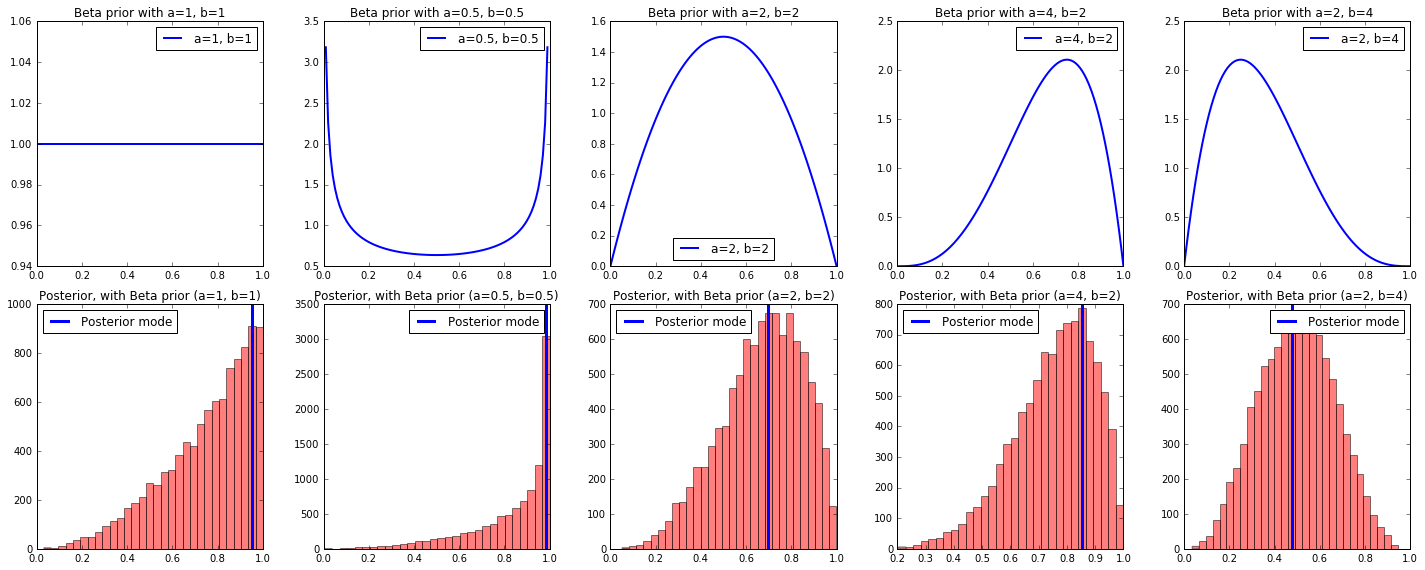

In [22]:
#Get the name of the first movie in the top 25 list
movie_name = 'French Twist'

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(2, n, figsize=(20, 8))

ax = plot_prior_posterior(movie_name, ax)

plt.tight_layout()
plt.show() 

When $a=1$ and $b=1$, the beta prior is the standard uniform distribution - all values between 0 and 1 are equally likely. This means that it's just as likely for the like-probability of "French Twist" to be zero (i.e. we think that no one will like the movie) as it is for the like-probability of the movie to be one (i.e. everyone will like this movie). Furthermore, it is just as likely that the like-probability is n% (i.e. any number of people may like this movie). This prior is simply saying that we have no prior beliefs about the likability of "French Twist".

When $a=0.5$ and $b=0.5$, the pdf of the beta prior is peaked at 0 and 1 - the values of 0 and 1 are highly likely and other values are unlikely. This means that we believe that "French Twist" if polarizing, people are likely to hate it (zero percent like-probability) or hate it (100 percent like-probability), but they are very unlikely to feel neutrally about it.

When $a=2$ and $b=2$, the pdf of the beta prior is peaked at 0.5 - the value of 0.5 is most likely. This means that we believe that viewers are equally likely to like or dislike "French Twist" (the movie is mediocre). 

When $a=4$ and $b=2$, the pdf of the beta prior is peaked above 0.5. This means that we believe viewers will tend to like the movie. On the other hand, when $a=2$ and $b=4$, the pdf of the beta prior is peaked below 0.5. In this case, we believe that viewers will tend to dislike the movie.

Our choices of priors have significant impacts on the posterior distributions over like-probability (given the data). The MAP estimates of the like-probability of "French Twist" ranges from 0.45 to nearly 1, depending on the prior. 

Toy Story: 0.745098039216 (38.0/51.0)


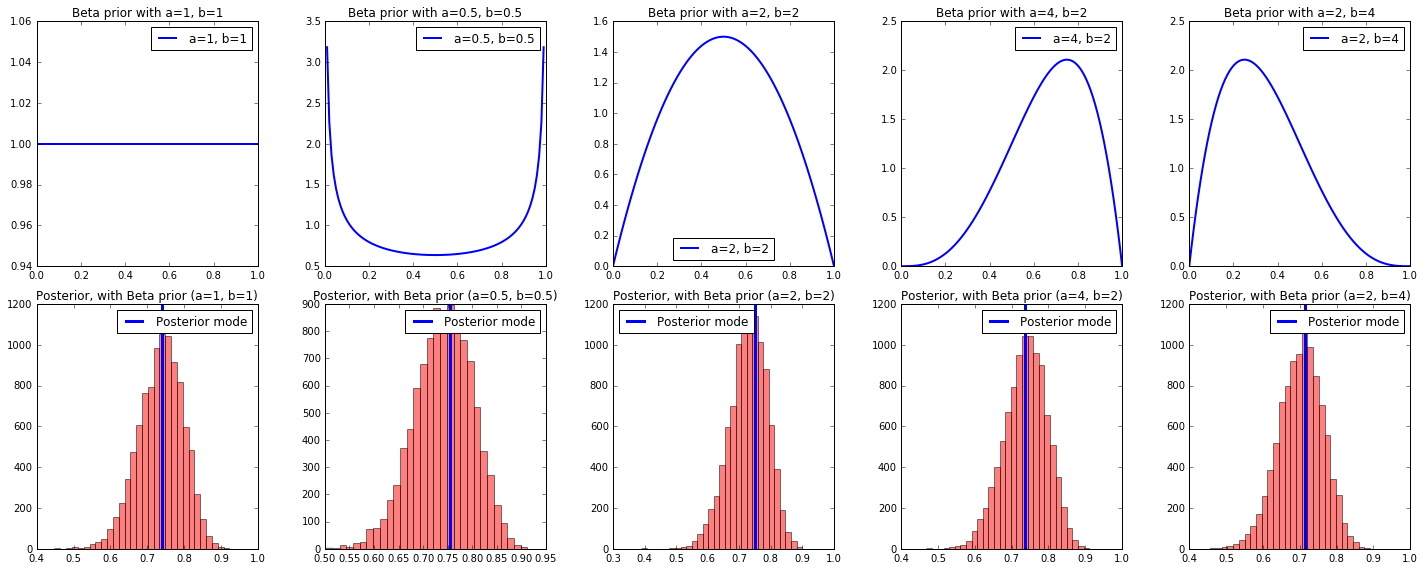

In [24]:
#Get the name of the first movie in the top 25 list
movie_name = 'Toy Story'

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(2, n, figsize=(20, 8))

ax = plot_prior_posterior(movie_name, ax)

plt.tight_layout()
plt.show() 

Unlike "French Twist", our choice of prior seems to have little effect on the MAP estimate of like-probability for "Toy Story"! 

The MLE estimate, the like-percentage, is $\frac{38}{51}\approx 75\%$. For all five priors, the MAP estimate is close to 75% as well! The lowest MAP estimate is 72%, corresponding to the prior indicating the belief that most people will dislike the movie. That is, even if we incorporate the belief that most people will dislike "Toy Story", our bias does little to lower the actual estimate of the like-probability of the movie!

So why does our choice of prior have such a striking effect on "French Twist" and such little effect on "Toy Story"? The difference between the two movies is that "Toy Story" has a large number of ratings and "French Twist" has very few. This is suggesting that when the evidence is scant, our judgment tends to be determined largely by prior beliefs. However, in the face of overwhelming evidence our prior beliefs have a diminished effect on our overall judgment. This makes intuitive sense. To support our conclusion, let's do some systematic experimentation on the effect of evidence and prior on our posterior estimates.

We will perform our experiement on ratings for "Star Wars": we will sample different numbers of ratings for "Star Wars"; for each sample of ratings, we will visualize the effect of our choice of priors on the posterior distribution.

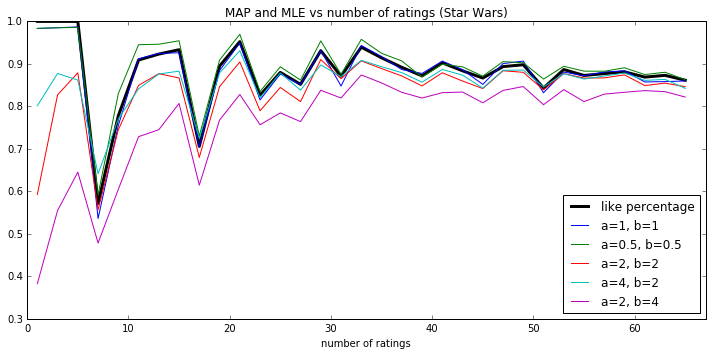

In [44]:
#Get the ratings info for Star Wars
total_ratings, likes = movie_stats(movie_name_contains="Star Wars")
dislikes = total_ratings - likes

ratings = [1] * int(likes) + [0] * int(dislikes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)
#Number of samples to use when approximating our posterior
n_samples = 10000

MAP_est = []
MLE_est = []

for s in range(1, int(total_ratings), 2):
    rating_sample = np.random.choice(ratings, size=s, replace=False)
    s_likes = len(rating_sample[rating_sample == 1])
    MLE_est.append(s_likes / float(s))
    
    MAP_est_s = []
    #Plot all the posterior distributions in a row
    #Iterate through all the shapes
    for a, b in beta_shapes:   
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, s_likes, s, n_samples)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        MAP_est_s.append(mode)
        
    MAP_est.append(MAP_est_s)

MAP_est = np.array(MAP_est)
col = 0
ax.plot(range(1, int(total_ratings), 2), MLE_est, color="black", linewidth=3, label='like percentage')
for a, b in beta_shapes:
    ax.plot(range(1, int(total_ratings), 2), MAP_est[:, col], label='a={}, b={}'.format(a, b))
    col += 1
ax.set_title('MAP and MLE vs number of ratings (Star Wars)')
ax.set_xlabel('number of ratings')
ax.set_xlim([0, 67])
ax.legend(loc='best')
plt.tight_layout()
plt.show() 

As you can see in the above graph, when the number of ratings is small, the various MAP estimates of like probability are very different from each other and very different from the like percentage. But as the number of ratings increases, all estimates converge to the same number (the effect of the prior on the MAP estimate is drastically less observable). This empirically confirms our intuition: priors have more influece on MAP estimates when evidence is scant and less when evidence is abundant. In fact, when evidence is very abundant, it looks like MAP and MLE estimates of the like-probability are very similar.

### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

**Solution:**

Recall that the point of incorporating priors into our probabilistic model is to bias our final judgement against evidence (add counter-weight to the evidence) to prevent overfitting (making extreme conclusions based on little evidence). That is, when we see a high like-percentage in a movie that is reviewed by few people, we want to give an estimate of the "likability" of the movie that is lower than the like-percentage. From our experimentation with incorporating priors for "French Twist", we see that by using priors that are peaked around 0.5 (or below), the MAP estimate of like-probability is lower than the like-percentage. Thus, for our moive database, we will choose a beta prior with $a=2$ and $b=2$.

Note that we can also choose a different prior for each movie, but that will be computationally expensive and, since I haven't seen all these movies, difficult to do. Since the basic goal is to down weight high like-percentages with few ratings, and up weight high like-percentages with many ratings, choosing one prior ($a=2$ and $b=2$) will do!

In [25]:
#Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.979426517903 (39.0/39.0)
Glory (1989) : 0.963764968842 (17.0/17.0)
Cool Hand Luke (1967) : 0.963210872542 (20.0/20.0)
Godfather: Part II, The (1974) : 0.958435326766 (18.0/18.0)
Manchurian Candidate, The (1962) : 0.948880972985 (17.0/17.0)
Wrong Trousers, The (1993) : 0.939069206471 (14.0/14.0)
Raiders of the Lost Ark (1981) : 0.938731686525 (47.0/49.0)
Casablanca (1942) : 0.935291632476 (22.0/23.0)
Local Hero (1983) : 0.931593160809 (10.0/10.0)
Vertigo (1958) : 0.927669262366 (22.0/23.0)
Three Colors: Red (1994) : 0.919831098253 (12.0/12.0)
Killing Fields, The (1984) : 0.919192935499 (14.0/14.0)
Three Colors: White (1994) : 0.91717479732 (8.0/8.0)
High Noon (1952) : 0.910433045079 (11.0/11.0)
Alien (1979) : 0.907828355933 (28.0/30.0)
Henry V (1989) : 0.904286201024 (16.0/17.0)
Third Man, The (1949) : 0.9026442784 (9.0/9.0)
Thin Man, The (1934) : 0.898354857712 (8.0/8.0)
Usual Suspects, The (1995) : 0.89826

So while "Shawshank Redemption" is still highly ranked, "French Twist" no longer appears on our top 25. This at least seems more intuitive.

So, in what important ways is our top 25 list using the posterior mode different from our top 25 list using the like-percent? All the movies with just a couple or few ratings have all disappeared from our top 25 list, this is exactly what we wanted!

---

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Boston estimates that, while the total population in the area is roughly constant through time, there is approximately a 25% yearly increase in high-income households; and a corresponding decrease (in terms of the number of people) in the remaining population, with the decrease in the number of people being roughly the same amongst both the middle class and lower income households.

Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

**Solution:**

**The task**: in simple terms, the task we've been given is to deliver a product that will allow city employees to enter the location of a dwelling and a year and that will produce an accurate prediction of the income-bracket of the household in the dwelling.

Before choosing a model, let's consider the potential challenges of this task. One immediate challenge is that the proportions of population in these income-bracket categories may change (the number of high, middle and low income household may vary year to year), the distribution of household in these income brackets over the region may change (regions that contain middle income households in one year may contain only high income households in later years). Since changes in the data is the primary challenge for this task, let us first visualize the data across the years.

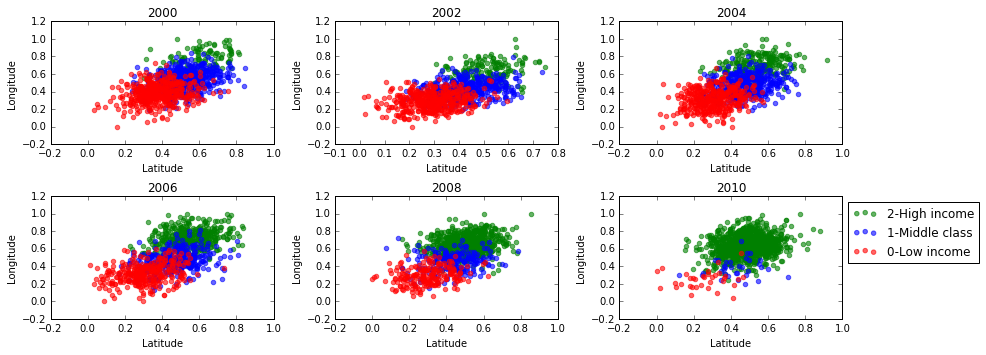

In [27]:
#Visualize data for every other year
fig, ax = plt.subplots(2, 3, figsize = (12, 5))

#Create index for subplots
ind = 0
#Iterate from year 0 to 10, with steps of 2
for i in range(0, 11, 2):
    #Load data
    data = np.loadtxt('datasets/dataset_1_year_' + str(2000 + i) + '.txt')
    
    #Split into predictor/response
    x = data[:, :-1]
    y = data[:, -1]
    
    #Plot each class for the current year in different colors
    ax[ind / 3, ind % 3].scatter(x[y == 2, 0], x[y == 2, 1],
                                 color='green', alpha=0.6,
                                 label = '2-High income')
    ax[ind / 3, ind % 3].scatter(x[y == 1, 0], x[y == 1 ,1], 
                                 color='blue', alpha=0.6,
                                 label = '1-Middle class')
    ax[ind / 3, ind % 3].scatter(x[y == 0, 0], x[y == 0, 1], 
                                 color='red', alpha=0.6,
                                 label = '0-Low income')
    
    # LABEL AXIS, TITLE
    ax[ind / 3, ind % 3].set_xlabel('Latitude')
    ax[ind / 3, ind % 3].set_ylabel('Longitude')
    ax[ind / 3, ind % 3].set_title(str(2000 + i))
    
    #Update index
    ind += 1

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.tight_layout()

From our data visualization, it looks like two things are happening:

- in this region, the number of household in middle and low income brackets are decreasing over the years while the number in the high income bracket is increasing (i.e. the cluster of green gets bigger, the other clusters get smaller).
 
- in this region, the number of **dwellings** in the middle and low income neighbourhoods are decreasing, while the number is increasing in the high income neighborhood (i.e. there are less dots of any color in the red and blue regions)! This can be due to the fact that, while some housing in the middle and low income neighborhoods are becoming high-income housing, simultaneously, the number of residential housing options may be decreasing in these neighborhoods, e.g. changes in zoning. 

We compare the following simple classification schemes for this problem:

1. Training a weighted logistic regression model yearly (with different weights accounting for the imbalance in class proportions)
2. Training a Q/LDA model yearly
3. Training one weighted logistic regression model (with different weights accounting for the imbalance in class proportions) on one year and use it repeatedly
4. Training one Q/LDA model on one year and use it repeatedly
5. Training one KNN model on one year and use it repeatedly
5. KNN yearly

**Note:** since we can already see that, for most years, the classes are not balanced (some classes are small whereas others are very large). We already know that a weighted version of logistic regression (see Challenge Problem HW5) may be better suited than ordinary logistic regression. To weight the classes in logistic regression so that scarce classes are given more attention, set the `class_weight` parameter in `sklearn`'s logistic regression model to `'balanced'`.

Since we are building a product to be used by, presumably, people who are not experts in data science or machine learning. We need to consider a wide range of ways to evaluate our model (we should always do this, regardless of the intended end-user of the model or product). The factors of model "goodness" we will consider include:

1. general predictive accuracy: at the very least, we want a model that makes accurate predictions.
2. predictive accuracy on each class: since for most years, there will be a large class imblance between the three classes, we need to worry about the meaningfulness (or lack thereof) of general predictive accuracy scores.
3. computational efficiency: we need to worry about how much computing or data storage resources are accessible to the end-user (building a model that your user can't run will be completely pointless).
4. interpretability of the model and results: we need to worry about whether or not our model is easy for the user to operate, how interpretable are the outputs of our model and whether or not it's possible for the end-user to detect and diagnose problems in our model should they ever arise.


Clearly training a single model (logistic regression, LDA or KNN) once, say on 2000 data, and then using this model to make predictions in all subsequent years is the most computationally efficient (the cost of training is paid once rather than repeatedly). But are these models accurate through time?


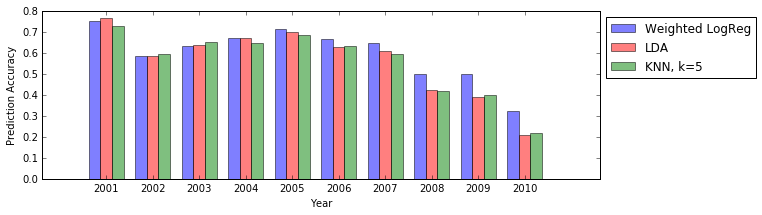

In [19]:
#Load data for year 2000
data = np.loadtxt('datasets/dataset_1_year_2000.txt')

#Split predictors, response
x = data[:, :-1]
y = data[:, -1]

#Fit a logistic regression model on year 2000 data
logreg = linear_model.LogisticRegression(class_weight='balanced')
logreg.fit(x, y)

#Fit a lda model on year 2000 data
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x, y)

#Fit a knn model on year 2000 data
knn = KNN()
knn.fit(x, y)

acc_log = []
acc_lda = []
acc_knn = []

#Iterate through all the years
for i in range(1, 11):
    #Load data for year 2000 + i 
    data_i = np.loadtxt('datasets/dataset_1_year_' + str(2000 + i) + '.txt')
    
    #Split predictors, response
    x_i = data_i[:, :-1]
    y_i = data_i[:, -1]

    #Compute predictive accuracies of various models trained on 2000 data
    acc_log.append(logreg.score(x_i, y_i))
    acc_lda.append(lda.score(x_i, y_i))
    acc_knn.append(knn.score(x_i, y_i))
            
#Plot accuracy over years
years = np.arange(1,11) + 2000 # x-axis is years 2001-2010
width = 0.25 # width of bar

plt.figure(figsize = (10,3))
plt.bar(years, acc_log, width, color='blue', alpha=0.5, label='Weighted LogReg')
plt.bar(years + width, acc_lda, width, color='red', alpha=0.5, label='LDA')
plt.bar(years + 2 * width, acc_knn, width, color='green', alpha=0.5, label='KNN, k=5')

#Labels
plt.xlabel('Year')
plt.ylabel('Prediction Accuracy')
plt.legend(loc = 'upper left', bbox_to_anchor=(1,1)) # legend upper left outside
plt.xticks(years + width + 0.125, years); # set x-ticks spacing

As we can see, all three models perform well in the years immediately following 2000 but their performaces (in terms of predictive accuracy) decreases drastically as the years go on. Thus, training the model once and using it for many years is not a good idea.

Back to our list of modeling options:

1. Training a weighted logistic regression model yearly (with different weights accounting for the imbalance in class proportions)
2. Training a Q/LDA model yearly
3. ~~Training one weighted logistic regression model (with different weights accounting for the imbalance in class proportions) on one year and use it repeatedly~~
4. ~~Training one Q/LDA model on one year and use it repeatedly~~
5. ~~Training one KNN model on one year and use it repeatedly~~
6. KNN yearly

What does it mean to train a model for each year? For KNN this means that in order to make a prediction give any year we have to keep **all** the data for every single year (in the past, present and future), since the model requires the entire data set for nearest neighbor comparisons. The cost of storing the data shoul be considered. Furthermore, for each new year (say for 2011 or 1999), we need to provide KNN with the population data for that year before we can make a prediction. The time it takes KNN to make a prediction is in the order of $Train*Test$, where Train is the number of training data points and Test is the number of test points. This can be quite expensive.

What does it mean to train a logistic regression model for each year? Since logistic regression model requires the entire dataset in order to find the best boundaries for classfication, it too requires that we provide the population data for each new year, retrain the model on the new data and make predictions for the new year using the new model. Thus, for each year there will be a computational cost for training the logistic regression model, but the the time it takes for logistic regression to make a prediction is proportional to the number of classes - so in this case, the predictions will be fast to compute. Finally, once the model is trained for the year, we no longer need to store the data with which we trained the model - we just need to remember the coefficients for the decision boundary, $\beta$'s! Compared to KNN (where data from all years must be stored and accessible), it is much less costly to store logistic regression model for multiple years.

What does it mean to train a QDA or LDA model for each year? Recall that Q/LDA classifiers first model the distribution of the data within each class using a normal distribution, $\mathcal{N}(\mu, \Sigma)$. Then the Q/LDA models the distribution of the data amongst the classes. For us, since we have three classes, this means that our "model" consists of the following 9 pieces of information (three for each class, two to define the distribution of data in the class and one to define the class proportion):

1. Class 0: 
   - Distribution: $p(x | y = 0) = \mathcal{N}(\mu_0, \Sigma_0)$
   - Proportion: $p(y=0)=\pi_0 = \frac{\text{data in Class 0}}{\text{total number of data}}$

2. Class 1: 
   - Distribution: $p(x | y = 1) = \mathcal{N}(\mu_1, \Sigma_1)$
   - Proportion: $p(y=1)=\pi_1 = \frac{\text{data in Class 1}}{\text{total number of data}}$
   
3. Class 2: 
   - Distribution: $p(x | y = 2) = \mathcal{N}(\mu_2, \Sigma_2)$
   - Proportion: $p(y=2)=\pi_2 = \frac{\text{data in Class 2}}{\text{total number of data}}$
   
Retraining a Q/LDA model means re-estimating $\mu_i, \Sigma_i$ and $\pi_i$. To re-estimate these quantities for a new year, do we need the entire set of population data for that year? Recall that the city of Boston has provided us with a projected yearly growth rate for Class 0, specifically, 
$$
\pi_0^{\text{year i + 1}} = \pi_0^{\text{year i}}  + 0.25 * \pi_0^{\text{year i}} = 1.25 * \pi_0^{\text{year i}}
$$
Now, since the total population stays roughly constant throughout the years, and the remaining two classes are decreasing by the same amount each year, we can calculate the proportions for Class 1 and Class 2:
$$
\pi_1^{\text{year i + 1}}  = \pi_2^{\text{year i + 1}} = \frac{1 - 1.25 * \pi_0^{\text{year i}}}{2}
$$
So we see that we don't need to see the actual data from year to year in order to estimate the class proportions.

On the other hand, if the distribution of the data within each class changes (i.e. $\mu_i$ and $\Sigma_i$ changes) then we will need re-estimate them using new data each year. Let's check, using data visualization, to see if this is indeed the case.

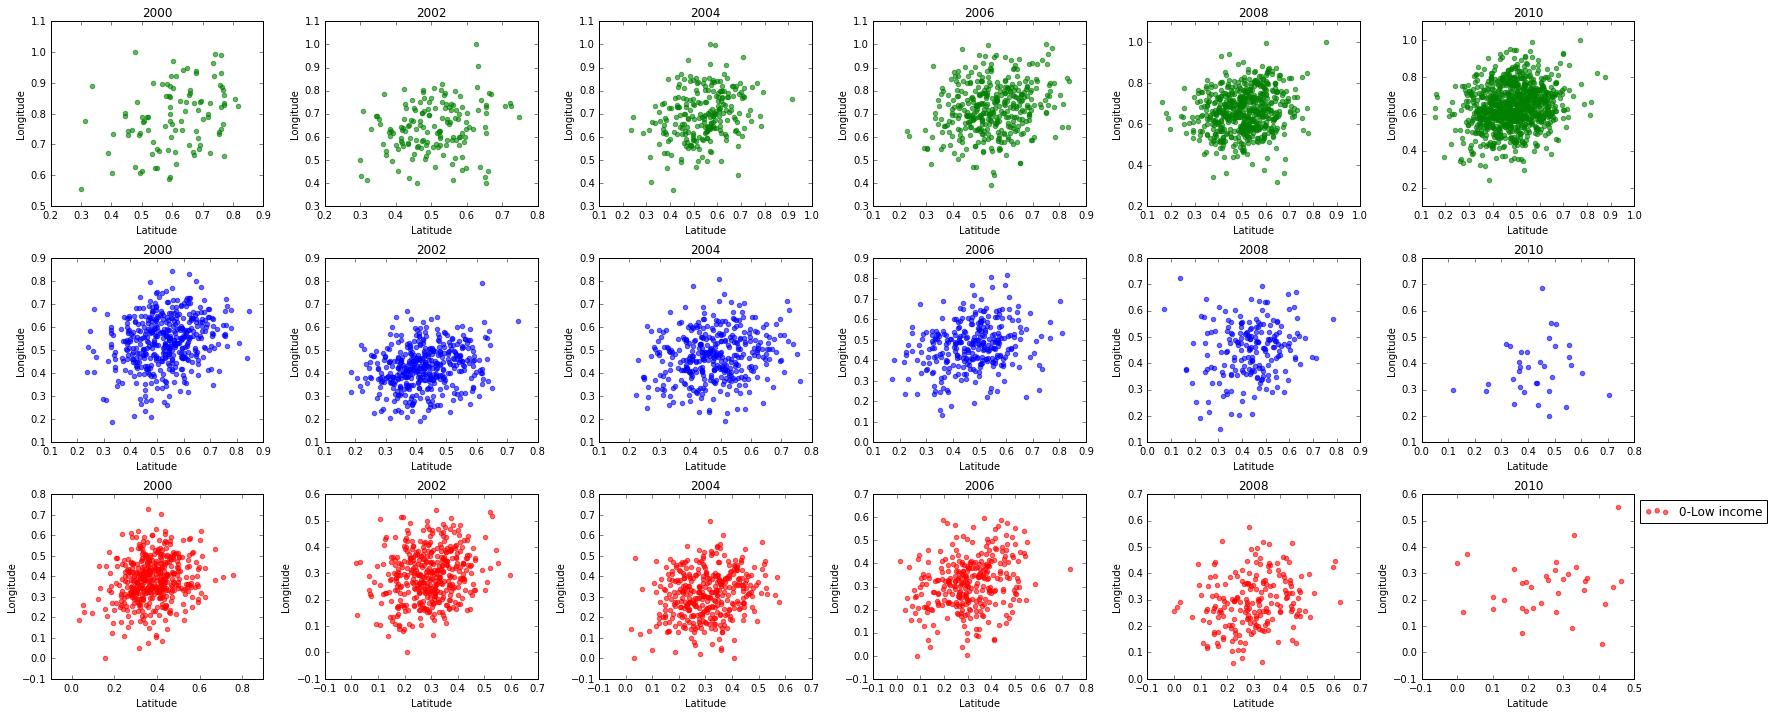

In [26]:
#Visualize data for every other year
fig, ax = plt.subplots(3, 6, figsize = (23, 10))

#Iterate from year 0 to 10, with steps of 2
for i in range(0, 11, 2):
    #Load data
    data = np.loadtxt('datasets/dataset_1_year_' + str(2000 + i) + '.txt')
    
    #Split into predictor/response
    x = data[:, :-1]
    y = data[:, -1]
    
    #Plot each class for the current year in different colors
    ax[0, i / 2].scatter(x[y == 2, 0], x[y == 2, 1],
                         color='g', alpha=0.6,
                         label = '2-High income')
    ax[1, i / 2].scatter(x[y == 1, 0], x[y == 1 ,1], 
                         color='b', alpha=0.6,
                         label = '1-Middle class')
    ax[2, i / 2].scatter(x[y == 0, 0], x[y == 0, 1], 
                         color='r', alpha=0.6,
                         label = '0-Low income')
    
    #Labels
    ax[0, i / 2].set_xlabel('Latitude')
    ax[0, i / 2].set_ylabel('Longitude')
    ax[0, i / 2].set_title(str(2000 + i))
    
    #Labels
    ax[1, i / 2].set_xlabel('Latitude')
    ax[1, i / 2].set_ylabel('Longitude')
    ax[1, i / 2].set_title(str(2000 + i))
    
    # LABEL AXIS, TITLE
    ax[2, i / 2].set_xlabel('Latitude')
    ax[2, i / 2].set_ylabel('Longitude')
    ax[2, i / 2].set_title(str(2000 + i))


plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.tight_layout()

It seems reasonable to conclude from visualization of the data in each class over the years that the distribution within each class is not changing! That is, the data in each class is approximately normally distributed and the shapes of these distributions are roughly constant over time (the number of points in the class doesn't theoretically contribute to the shape of the distribution, shape describes the variance in each direction). **From this we find it reasonable to conclude that the parameters $\mu_i$ and $\Sigma_i$ do not need to be updated each year**. Thus, updating our Q/LDA model yearly involves only re-estimating the class proportions using a formula based on projected yearly growth!

So how efficient is our Q/LDA model? We train the model once on a single year's worth of data. Then, for any subsequent year, the update is just a few lines of arithmetic. For example, say we train our Q/LDA model on 2000 data, given a point from 2001, $x^{2001}$, we predict the class label for $x^{2001}$ by:

1. find the probability that $x^{2001}$ will be labeled Class 0 to 2 using our model from 2000:
$$
\begin{aligned}
p_{2000}(y=0 | x^{2001}) &= p_{2000}(x^{2001} | y=0) p_{2000}(y=0) = \mathcal{N}(x^{2001}; \mu_0, \Sigma_0) \pi_0^{2000}\\
p_{2000}(y=1 | x^{2001}) &= p_{2000}(x^{2001} | y=1) p_{2000}(y=1) = \mathcal{N}(x^{2001}; \mu_1, \Sigma_1) \pi_1^{2000}\\
p_{2000}(y=2 | x^{2001}) &= p_{2000}(x^{2001} | y=2) p_{2000}(y=2) = \mathcal{N}(x^{2001}; \mu_2, \Sigma_2) \pi_2^{2000}
\end{aligned}
$$
2. adjust the probabilities predicted using the 2000 model, by updating $\pi_i$ with 2001 class proportions:
$$
\begin{aligned}
p_{2001}(y=0 | x^{2001}) &= p_{2000}(y=0 | x^{2001}) \frac{\pi_0^{2001}}{\pi_0^{2000}}\\
p_{2001}(y=1 | x^{2001}) &= p_{2000}(y=1 | x^{2001}) \frac{\pi_1^{2001}}{\pi_1^{2000}}\\
p_{2001}(y=2 | x^{2001}) &= p_{2000}(y=2 | x^{2001}) \frac{\pi_2^{2001}}{\pi_2^{2000}}\\
\end{aligned}
$$
3. take the max of $\{p_{2001}(y=0 | x^{2001}), p_{2001}(y=1 | x^{2001}), p_{2001}(y=2 | x^{2001}) \}$ and predict the class label corresponding to the max probability.

In terms of efficiency, clearly updating a Q/LDA model is more efficient than retraining a KNN or logistic regression each year. But is the accuracy comparable? Let's see.

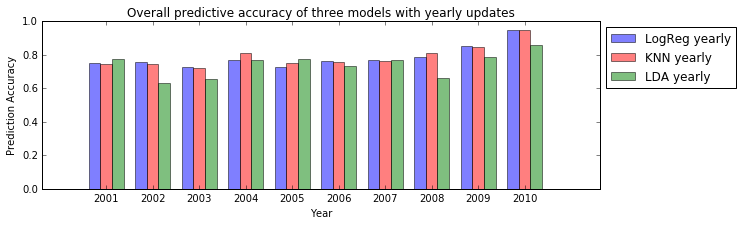

In [43]:
#Load data for year 2000
data = np.loadtxt('datasets/dataset_1_year_2000.txt')

#Split predictors, response
x = data[:, :-1]
y = data[:, -1]

#Fit a lda model on year 2000 data
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x, y)

acc_logreg = [] # Store LogReg accuracies
acc_knn = [] # Store LDA accuracies
acc_lda_corrected = [] # Store corrected LDA accuracies

#Store class proportions in 2000
p0_2000 = (y==0).mean()
p1_2000 = (y==1).mean()
p2_2000 = (y==2).mean()

#Store class proportions in current year
p0_current = (y==0).mean()
p1_current = (y==1).mean()
p2_current = (y==2).mean()

for k in range(1, 11):
    #Load data
    data_i = np.loadtxt('datasets/dataset_1_year_' + str(2000 + k) + '.txt')
    
    #Split into predictor, response
    x_i = data_i[:, :-1]
    y_i = data_i[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(x_i, y_i, test_size=0.30, random_state=0)
    
    #Fit a knn model on current year
    knn = KNN()
    knn.fit(x_train, y_train)
    
    #Fit a weighted logistic regression model on current year
    logreg = linear_model.LogisticRegression(class_weight='balanced')
    logreg.fit(x_train, y_train)

    #Compute accuracies for knn and weighted log reg
    acc_logreg.append(logreg.score(x_test, y_test))
    acc_knn.append(knn.score(x_test, y_test))
        
    #Re-estimate class proportions (25% increase in p2, adjust p0, p1 accordingly)
    p2_current = p2_current * 1.25
    p0_current = (1 - p2_current) / 2
    p1_current = (1 - p2_current) / 2
                
    #Re-estimate class label probabilities 
    pred_logprob = lda.predict_log_proba(x_test) # compute log-probabilities
    pred_logprob[:, 0] = pred_logprob[:, 0] + np.log(p0_current / p0_2000) # correction for class 0
    pred_logprob[:, 1] = pred_logprob[:, 1] + np.log(p1_current / p1_2000) # correction for class 1
    pred_logprob[:, 2] = pred_logprob[:, 2] + np.log(p2_current / p2_2000) # correction for class 2
    
    #Predict class label using re-estimated probabilities
    y_pred = pred_logprob.argmax(axis = 1)
    
    #Compute accuracy 
    acc_lda_corrected.append(np.mean(y_test == y_pred))
    
#Plot accuracy over years
years = np.arange(1, 11) + 2000 # x-axis is years 2001-2010
width = 0.25 # width of bar

plt.figure(figsize=(10,3))
plt.bar(years, acc_logreg, width, color='blue', alpha=0.5, label='LogReg yearly')
plt.bar(years + width, acc_knn, width, color='red', alpha=0.5, label='KNN yearly')
plt.bar(years + 2 * width, acc_lda_corrected, width, color='green', alpha=0.5, label='LDA yearly')

#Labels
plt.xlabel('Year')
plt.ylabel('Prediction Accuracy')
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1)) # legend upper left outside
plt.title('Overall predictive accuracy of three models with yearly updates')
plt.xticks(years + width + 0.125, years); # set x-ticks spacing

It looks like in 5 out of the 9 years, all three models have comparable performance in terms of predictive accuracy. in 4 out of the 9 years Q/LDA  has lower performance than weighted logistic regression and KNN, trained on that year's data.

**Loose ends:** 

1. Why LDA and not QDA? Well since we've already observed that the distributions of data within the three classes are very simliar (in terms of shape) we can assume that the covariance matrices for all three classes will be the same - hence our model is LDA rather than QDA

2. How did we pick $k$ for KNN? In our implementation, we used the default setting $k = 5$. However, if we really want to tune the performance of KNN we need to select the optimal value of $k$ using cross-validation. If we want to have an optimal KNN model each year, not only do we need to retrain (retain the entire data set for each year) we need to retune the optimal value of $k$! This is an additional cost!

3. What happens after 2011? Clearly if Class 0 keeps growing at a rate of 25% per year, at some point, the entire region will be Class 0. This will happen in 2011. At this point, if you accept the projeted growth rate estimated by the city of Boston, your model should predict every household in 2011 to be in Class 0.

**Conclusion:** Based on the data visualization from the first 5 years, it's clear that while the class proportions are changing, the class distributions are not (the center and shape of the three classes are constant through time). Thus, updating our LDA on a yearly basis is simple, as this just requires us to adjust our estimates of the class proportions $\pi$. With logistic regression, on the other hand, we will have to re-train the model for each year, with different weights on the classes. With KNN, again, we need to retrain the model and re-tune the hyperparameter $k$ each year. 

As we can see from our accuracy plot, although LDA at times under performs in comparison with re-trained KNN and logistic regression, the difference in the performance can be considered acceptable, especially in light of the computational efficiency gained by using LDA. Furthermore, in years where KNN and logistic regression under perform, it may be difficult to diagnose the problem (is there something wrong with the data or the model?), since both models make so little assumptions about the data. In contrast, in years where LDA under performs, we can pin-point the source of the problem to a bad estimate of $\mu_i$, $\Sigma_i$, $\pi_i$ or to the failure of a model assumption.

In the end, for the above reasons, we recommend training an LDA model on the data from year 2000 and then updating yearly by adjusting class porportions in the LDA model. 

(**Note:** you may very well have recommeneded a different model. This is fine as long as your reasoning is sound and supported by evidence.)

### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1: high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

**Solution:**

Again we compare a few simple models:

1. logistic regression with linear and quadratic terms
2. Q/LDA
3. KNN

Let's first visualize the data to see if there are any potential pathologies or challenges to modeling.

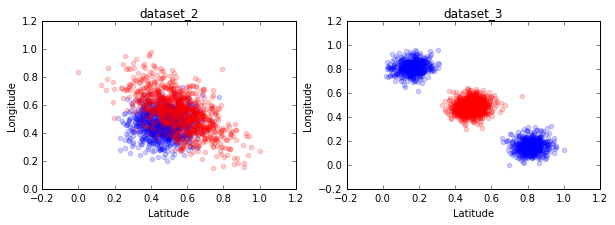

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

data = np.loadtxt('datasets/dataset_2.txt')
x = data[:,0:-1]
y = data[:,-1]

# Plot data
ax[0].scatter(x[y == 1, 0], x[y == 1, 1], color='b', alpha=0.2)
ax[0].scatter(x[y == 0, 0], x[y == 0, 1], color='r', alpha=0.2)

# Label axes, set title
ax[0].set_title('dataset_2')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Longitude')

data = np.loadtxt('datasets/dataset_3.txt')
x = data[:,0:-1]
y = data[:,-1]

# Plot data
ax[1].scatter(x[y == 1, 0], x[y == 1, 1], color='b', alpha=0.2)
ax[1].scatter(x[y == 0, 0], x[y == 0, 1], color='r', alpha=0.2)

# Label axes, set title
ax[1].set_title('dataset_3')
ax[1].set_xlabel('Latitude')
ax[1].set_ylabel('Longitude')

plt.show()

Since the classes in `dataset_2` overlap, we anticipate that KNN will do poorly; similarly, since the classes in `dataset_3` are well-separated, we expect KNN to do well. Whether or not it does better than logistic regression or Q/LDA, we leave for you to explore. We will concentrate on choosing between Q/LDA and logistic regression with various types of decision boundaries. 

Rather than computing predictive accuracies and using these to guide our model selection, let's see if we can perform model selection based on visualization. That is, let's analyze the data and the decision boundaries of each model.

In [51]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='b')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='r')
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [58]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      file_name (name of the file containing dataset)
# Returns: 
#      None

def fit_and_plot_models(file_name): 
    data = np.loadtxt(file_name)
    x = data[:,0:-1]
    y = data[:,-1]

    fig, ax = plt.subplots(1, 4, figsize=(15, 3))

    # Plain Logistic Regression
    logreg = linear_model.LogisticRegression()
    logreg.fit(x, y)
    acc_logreg = logreg.score(x, y)

    str_title = 'LogReg (acc = ' + str(acc_logreg) + ')'
    ax[0] = plot_decision_boundary(x, y, logreg, False, str_title, ax[0])

    # LDA
    lda = discriminant_analysis.LinearDiscriminantAnalysis()
    lda.fit(x, y)
    acc_lda = lda.score(x, y)

    str_title = 'LDA (acc = ' + str(acc_lda) + ')'
    ax[1] = plot_decision_boundary(x, y, lda, False, str_title, ax[1])

    # QDA
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    qda.fit(x, y)
    acc_qda = qda.score(x, y)

    str_title = 'QDA (acc = ' + str(acc_qda) + ')'
    ax[2] = plot_decision_boundary(x, y, qda, False, str_title, ax[2])

    # Logistic Regression with Quadratic Terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    logreg_poly = linear_model.LogisticRegression(C=1000)
    logreg_poly.fit(x_expanded, y)
    acc_logreg_poly = logreg_poly.score(x_expanded, y)
    
    str_title = 'LogReg-poly (acc = ' + str(acc_logreg_poly) + ')'
    ax[3] = plot_decision_boundary(x, y, logreg_poly, True, str_title, ax[3])
    
    plt.tight_layout()
    plt.show()

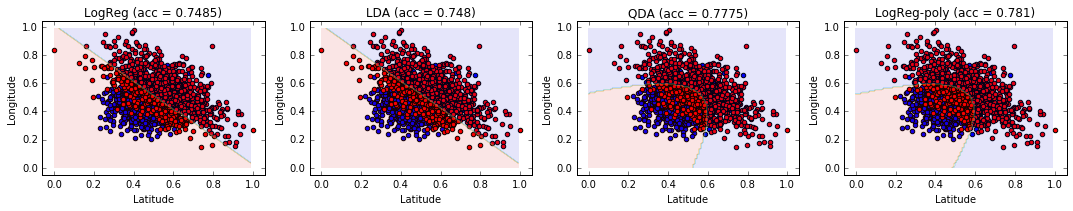

In [59]:
fit_and_plot_models('datasets/dataset_2.txt')

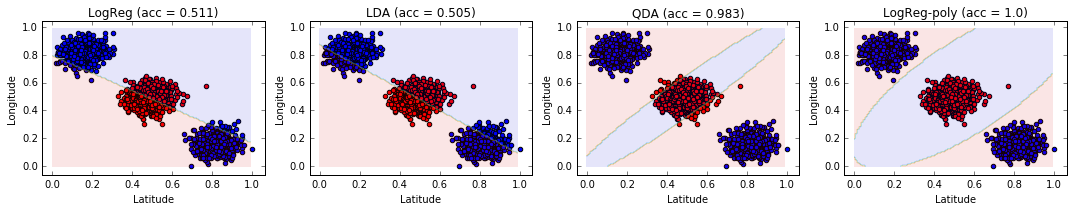

In [60]:
fit_and_plot_models('datasets/dataset_3.txt')

**Observation:** In the both datasets, the optimal decision boundary is quadratic (based on over all training accuracy and common sense). So both LDA and linear Logistic Regression yield poor prediction accuracy even on the training set.

Since the first data set satisfies the model assumptions in QDA (i.e. the distribution of the data within each class is normal), we are not surprised that QDA provides a similar fit as that of (unregularized) logistic with quadratic boundaries (the latter may be overfitting). 

For the second data set, however, the model assumptions in QDA fail (the red class is nomally distributed, but the blue is not)! On the other hand, logistic regression make no assumptions regarding the distribution of the data, it makes more sense to recommend a logistic regression model (although you should incorporate regularization to curb the over fitting).

---

## Challenge Problem: Regularization

We have seen ways to include different forms of regularizations in Linear regression and Logistic regression, in order to avoid overfitting. We will now explore ways to incorporate regularization within the discriminant analysis framework.

- When we have a small training sample, we end up with poor estimates of the class proportions $\pi_i$ and covariance matrices $\Sigma$. How can we regularize these quantities to improve the quality of the fitted model?


- We have seen that different assumptions on the covariance matrix results in either a linear or quadratic decision boundary. While the former may yield poor prediction accuracy, the latter could lead to over-fitting. Can you think of a suitable way to regularize the covariance to have an intermediate fit?

The solutions that you suggest must include a parameter that allows us to control the amount of regularization.

**Solution:**

- To avoid poor estimates from small sample sizes, we make slight changes to our estimators for $\pi_1$ and $\Sigma$. 
    - In the case of $\pi_1$, the following regularized estimator is robust to small sample sizes: $$\tilde{\pi}_1 \,=\, \frac{\sum_{i=1}^N y_i + \kappa}{N + 2\kappa},$$ where $\kappa$ is a parameter that controls the amount of regularization. Notice that for small sample sizes $N$, the estimate is close to $\frac{1}{2}$; on the other hand, when the sample size becomes large, the effect of the regularization dies out. It is easy to see from Problem 1, that the proposed estimator is the MAP estimator for $\pi_1$ when we assume a Beta prior distribution with parameters $\alpha = \beta = \kappa+1$.
    - In the case of the covariance matrix $\Sigma$, small sample sizes may lead to rank deficient estimates. This is problematic when we later need to invert the covariance matrix. To avoid this, we add a positive value to the diagonal entries of our estimate $\hat{\Sigma}$ to improve its rank. This gives us the following regularized estimate: $$\tilde{\Sigma}_i \,=\, \hat{\Sigma}_i \,+\, \lambda \mathbb{I}_{p\times p},$$ where $\lambda > 0$ is a parameter that controls the amount of regularization. It turns out that the proposed estimator is the MAP estimator for $\Sigma$ when we assume an Inverse-Wishart prior distribution.

- To strike a balance between a linear and quadratic decision boundary, we can shrink our per-class estimates covariance estimates $\hat{\Sigma}_i$ to a common covariance estimate $\hat{\Sigma}$: $$\tilde{\Sigma}_i \,=\, \gamma\hat{\Sigma}_i \,+\, (1-\gamma) \hat{\Sigma},$$ where $\gamma \in (0,1)$ is a parameter that controls the trade-off between assuming a covariance matrix for each class (which results in a quadratic decision boundary) and assuming a common covariance matrix for all classes (which results in a linear decision boundary). 